In [41]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scipy

import tensorNets.a_mps as a_mps
import tensorNets.d_dmrg as d_dmrg

from heisenbergModel import HeisenbergModel, HeisenbergModelNearestNeighbors, HeisenbergModelNoDecay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The Heisenberg model is build in `HeisenbergModel.py`. We only want to perform DMRG, so the only relevant function is `generate_H_mpo()`

rewrite Hamiltonian:
$$
H = J \sum_{i<j} \lambda ^{j-i} \sum_{\alpha = x,y,z} S_i^\alpha S_j^\alpha \qquad \lambda = e ^{-\frac{1}{\xi}}
$$

In [2]:
# hyperparameters
L = 10  # system size
J = 1.0  # coupling strength
XI = 1.0  # correlation length

In [3]:
def init_spindown_MPS(L):
    """Return a product state with all spins up as an MPS"""
    B = np.zeros([1, 2, 1], np.float64)
    B[0, 0, 0] = -1.
    S = np.ones([1], np.float64)
    Bs = [B.copy() for i in range(L)]
    Ss = [S.copy() for i in range(L)]
    return a_mps.MPS(Bs, Ss)

In [4]:
mps = init_spindown_MPS(L)
model = HeisenbergModel(L, J, XI)
engine = d_dmrg.DMRGEngine(mps, model)

In [5]:
engine.calculate_energy()

array(3.3293076)

In [6]:
model.H_mpo[0][1,1]

array([[0.36787944+0.j, 0.        +0.j],
       [0.        +0.j, 0.36787944+0.j]])

In [7]:
# function to run the DMRG algorithm

def run_dmrg_simulation(L, J, xi, max_sweeps=20, tol=1e-9):
    mps = a_mps.init_spinup_MPS(L)
    model = HeisenbergModel(L, J, xi)
    engine = d_dmrg.DMRGEngine(mps, model)

    # E_exact = tfi_exact.finite_gs_energy(L, J, g)

    E, E_prev = 0, 0

    for i in range(max_sweeps):
        engine.sweep()
        E_prev = E
        E = engine.calculate_energy()
        print("Energy:", E)
        # print("Energy error:", E - E_exact)
        if np.abs(E - E_prev) < tol:
            print(f"The system is converged after {i+1} sweeps!")
            break
    
    return model, mps, engine

In [8]:
model, mps, engine = run_dmrg_simulation(24, J, XI, tol=1e-10)

Energy: -8.916907090342445
Energy: -8.96464826734617
Energy: -8.964964767964279
Energy: -8.964964770428686
Energy: -8.964964770428637
The system is converged after 5 sweeps!


## Influence of $\xi$ on the Correlations

Do the same as in the problem sheet about DMRG. i is L/4 and calculate correlations for every $j > i$. then plot the correlations for different $\xi$ values.

In [60]:
def calculate_two_operator_expectation(psi, X, Y, i):
    """
    Calculate the expectation value of two operators on the MPS.
    <psi|X_i X_j|psi>
    where |psi> is the MPS.

    calculate for all j >= i
    
    """
    # first, move the center of orthogonality to the i-th site. 
    # not necessary because we safe all the laambdas in the MPS class

    return_list = []

    # first calculate the left hand structure. its always the same so we can precompute it.
    theta_i = psi.get_theta1(i) 
    X_theta_i = np.tensordot(X, theta_i, axes=[1, 1])  # i [i*], vL [i] vR
    left_exp_struct = np.tensordot(theta_i.conj(), X_theta_i, [[0, 1], [1, 0]]) # [vL*] [i*] vR*, [i] [vL] vR

    # update the left structure in the loop. 

    for j in range(i, psi.L):
        if j == i:
            op  = np.tensordot(X, Y, [1, 0]) # i, [i*] x [i] , i*
            # theta_op = np.tensordot(theta, op, [1,0]) # vl, [i], vr x [i], i*
            op_theta = np.tensordot(op, theta_i, axes=[1, 1])  # i [i*], vL [i] vR
            exp_val = np.tensordot(theta_i.conj(), op_theta, [[0, 1, 2], [1, 0, 2]]) # [vL*] [i*] [vR*], [i] [vL] [vR]
            return_list.append(exp_val)
        else:
            tmp = np.tensordot(Y, psi.Bs[j], axes=[1,1]) # i [i*], vL [i] vR
            right_side = np.tensordot(psi.Bs[j].conj(), tmp, axes=[[1,2],[0,2]])  # vL* [i*] [vR*], [i] vL [vR]
            exp_val = np.tensordot(left_exp_struct, right_side, [[0, 1], [0, 1]]) # [vR*] [vR], [vL*] [vL]
            return_list.append(exp_val)
            # update the left structure
            left_exp_struct = np.tensordot(left_exp_struct, psi.Bs[j], axes=[1,0]) # vR* [vR] x [vL], i, vR
            left_exp_struct = np.tensordot(left_exp_struct, psi.Bs[j].conj(), axes=[[1,0],[1,0]]) # [vR*] [i] vR x [vL*] [i*] vR*
            left_exp_struct = np.transpose(left_exp_struct, (1,0)) # vR* vR


    return np.array(return_list)

# e)
def correlation_function(psi, X, Y, i):
    L = psi.L
    assert i < L
    corrs = []
    # first case: j = i
    # Note: psi.get_theta(i) = Lambda[i] B[i] with axes vL i vR
    theta = psi.get_theta1(i)  # vL i vR
    X_Y_theta = np.tensordot(np.dot(X, Y), # i [i*], [i] i*
                             theta, axes=([1], [1]))  # i [i*], vL [i] vR
    contr = np.tensordot(theta.conj(), X_Y_theta, axes=([0, 1, 2], [1, 0, 2]))  # [vL*] [i*] [vR*], [i] [vL] [vR]
    corrs.append(contr)
    # now for i < j
    theta = psi.get_theta1(i)  # vL i vR
    LP = np.tensordot(X, theta, axes=([1], [1]))  # i [i*], vL [i] vR
    LP = np.tensordot(theta.conj(), LP, axes=([0, 1], [1, 0])) # [vL*] [i*] vR*, [i] [vL] vR
    # now LP has axes vR*, vR
    for j in range(i+1, L):
        # contract with B Y B* to evalluate the correlation function for given j
        B = psi.Bs[j]  # vL j vR
        Y_B = np.tensordot(Y, B, axes=([1], [1])) # j [j*], vL [j] vR
        contr = np.tensordot(LP, Y_B, axes=([1], [1])) # vR* [vR], j [vL] vR
        contr = np.tensordot(contr, B.conj(), axes=([0, 1, 2], [0, 1, 2])) # [vR*] [j] [vR], [vL*] [j*] [vR*]
        corrs.append(contr.item())
        # get next LP for next i
        LP = np.tensordot(LP, B, axes=([1], [0])) # vR* [vR], [vL] j vR
        LP = np.tensordot(B.conj(), LP, axes=([0, 1], [0, 1])) # [vL*] [j*] vR*, [vR*] [j] vR
    return np.real_if_close(corrs)


In [ ]:
xi_range = [0.1, 1., 10.] # for initial run, maybe use more later
L_for_correlations = 32

ground_states = []
sigmax = np.array([[0., 1.], [1., 0.]])

for xi in xi_range:
    print(f"Running DMRG simulation for xi = {xi}")
    model, mps, engine = run_dmrg_simulation(L_for_correlations, J, xi, tol=1e-10)
    ground_states.append(mps)



Running DMRG simulation for xi = 0.1
Energy: -13.456713419475415
Energy: -13.559660906066219
Energy: -13.56218894300409
Energy: -13.562189131573284
Energy: -13.56218913157333
The system is converged after 5 sweeps!
Running DMRG simulation for xi = 1.0
Energy: -12.060057247551882
Energy: -12.124637105040563
Energy: -12.125451746465902
Energy: -12.125451783624746
Energy: -12.125451783624738
The system is converged after 5 sweeps!
Running DMRG simulation for xi = 10.0
Energy: -5.182393451591189
Energy: -11.269548953083483
Energy: -11.503812823935075
Energy: -11.503813239875461
Energy: -11.50381323987824
The system is converged after 5 sweeps!


In [35]:
xi = 20
print(f"Running DMRG simulation for xi = {xi}")
model, mps, engine = run_dmrg_simulation(L_for_correlations, J, xi, tol=1e-10)
ground_states.append(mps)

Running DMRG simulation for xi = 20
Energy: -1.509275199089347
Energy: -9.752262288318242
Energy: -11.500827229938908
Energy: -11.500832400972817
Energy: -11.500832400973916
The system is converged after 5 sweeps!


In [61]:
sigmaz = np.array([[1., 0.], [0., -1.]])
Sz = sigmaz
correlations = [calculate_two_operator_expectation(mps, Sz, Sz, L_for_correlations // 4) for mps in ground_states]
correlations2 = [correlation_function(mps, Sz, Sz, L_for_correlations // 4) for mps in ground_states]

for reference, Heisenberg with only nearest neighbour interaction:

In [ ]:
# function to run the DMRG algorithm

def run_dmrg_simulation_only_NN(L, J, xi, max_sweeps=20, tol=1e-9):
    mps = a_mps.init_spinup_MPS(L)
    model = HeisenbergModelNearestNeighbors(L, J, xi)
    engine = d_dmrg.DMRGEngine(mps, model)

    # E_exact = tfi_exact.finite_gs_energy(L, J, g)

    E, E_prev = 0, 0

    for i in range(max_sweeps):
        engine.sweep()
        E_prev = E
        E = engine.calculate_energy()
        print("Energy:", E)
        # print("Energy error:", E - E_exact)
        if np.abs(E - E_prev) < tol:
            print(f"The system is converged after {i+1} sweeps!")
            break
    
    return model, mps, engine




In [ ]:
modelNN, mpsNN, engineNN = run_dmrg_simulation_only_NN(L_for_correlations, J, XI, tol=1e-9)


Energy: -6.104668904295224


ArpackNoConvergence: ARPACK error -1: No convergence (1281 iterations, 0/1 eigenvectors converged) [ARPACK error -14: ZNAUPD did not find any eigenvalues to sufficient accuracy.]

In [32]:
correlations_NN = calculate_two_operator_expectation(mpsNN, sigmaz, sigmaz, L_for_correlations // 4)

In [46]:
def expected_correlation_function(distance, xi):
    """
    Calculate the expected correlation function for a given lattice size L and correlation length xi.
    """
    return np.exp(-distance / xi)

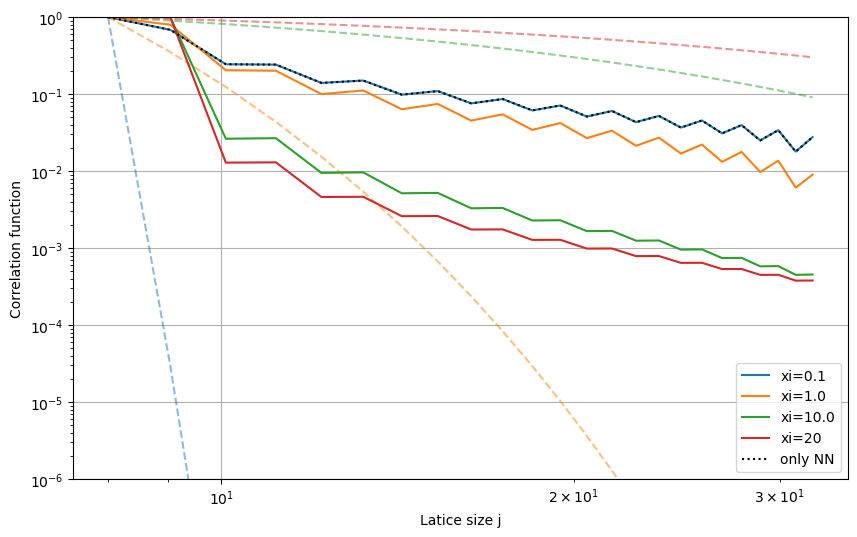

In [63]:
fig, ax = plt.subplots(figsize=(10, 6))

L_plot = np.linspace(L_for_correlations // 4, L_for_correlations, len(correlations[0]))

ax.set_yscale('log')
ax.set_xscale('log')

for i, g in enumerate(xi_range + [20]):
    ax.plot(L_plot, np.abs(correlations[i].real), label=f'xi={g}', color=f'C{i}')
    ax.plot(L_plot, expected_correlation_function(L_plot - L_for_correlations // 4, g), linestyle='--' ,color=f'C{i}', alpha=0.5)

ax.plot(L_plot, np.abs(correlations_NN.real), label='only NN', linestyle=':', color='black')

ax.set_xlabel("Latice size j")
ax.set_ylabel("Correlation function")

ax.set_ylim(1e-6, 1.0)

ax.legend()

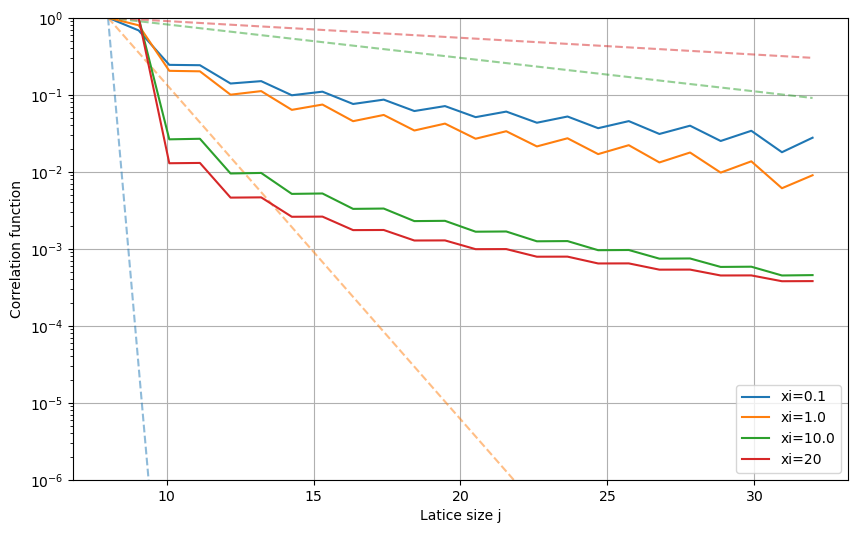

In [62]:
fig, ax = plt.subplots(figsize=(10, 6))

L_plot = np.linspace(L_for_correlations // 4, L_for_correlations, len(correlations[0]))

ax.set_yscale('log')

for i, g in enumerate(xi_range + [20]):
    ax.plot(L_plot, np.abs(correlations2[i]), label=f'xi={g}', color=f'C{i}')
    ax.plot(L_plot, expected_correlation_function(L_plot - L_for_correlations // 4, g), linestyle='--' ,color=f'C{i}', alpha=0.5)

# ax.plot(L_plot, np.abs(correlations_NN.real), label='only NN', linestyle=':', color='black')

ax.set_xlabel("Latice size j")
ax.set_ylabel("Correlation function")

ax.set_ylim(1e-6, 1.0)

ax.legend()